In [1]:
from google.colab import files
uploaded = files.upload()

Saving GOOGL.csv to GOOGL (1).csv


In [2]:
import tensorflow as tf
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import io
df = pd.read_csv(io.BytesIO(uploaded['GOOGL.csv']), parse_dates = True, index_col=0)
df.index.name = 'Date'
df

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL
...,...,...,...,...,...,...
2017-12-22,1070.00,1071.72,1067.64,1068.86,889446,GOOGL
2017-12-26,1068.64,1068.86,1058.64,1065.85,918767,GOOGL
2017-12-27,1066.60,1068.27,1058.38,1060.20,1116203,GOOGL


In [4]:
df = df.drop(columns='Name')
df

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450
2006-01-04,222.17,224.70,220.09,222.84,15292353
2006-01-05,223.22,226.00,220.97,225.85,10815661
2006-01-06,228.66,235.49,226.85,233.06,17759521
2006-01-09,233.44,236.94,230.70,233.68,12795837
...,...,...,...,...,...
2017-12-22,1070.00,1071.72,1067.64,1068.86,889446
2017-12-26,1068.64,1068.86,1058.64,1065.85,918767
2017-12-27,1066.60,1068.27,1058.38,1060.20,1116203


In [5]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

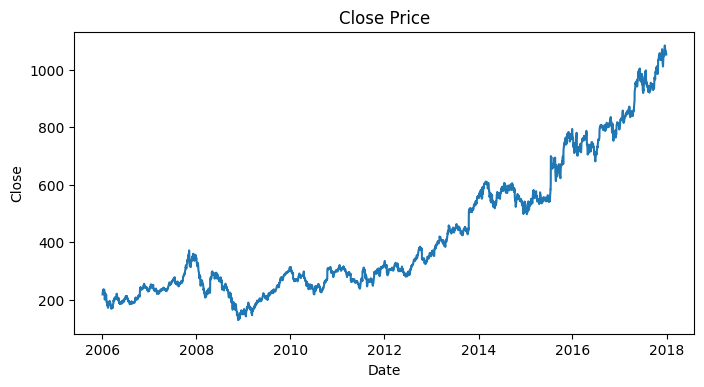

In [6]:
plt.figure(figsize=(8,4), dpi=100)
plt.plot(df.index, df['Close'].values)
plt.gca().set(xlabel="Date", ylabel="Close", title="Close Price")
plt.show()

In [7]:
import cv2

data = df['Close'].values
out = np.zeros(data.shape, np.double)
data = cv2.normalize(data, out, 1.0, 0.0, cv2.NORM_MINMAX)

In [8]:
len_train = int(len(data)*0.8)
data_train = data[:len_train]
data_val = data[len_train:]

In [9]:
len(data_train), len(data_val)

(2415, 604)

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
train_set = windowed_dataset(data_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(data_val, window_size=60, batch_size=100, shuffle_buffer=1000)

In [12]:
model = Sequential([
  Bidirectional(LSTM(64, return_sequences=True)),
  Bidirectional(LSTM(64)),
  Dropout(0.5),
  Dense(128, activation="relu"),
  Dense(64, activation="relu"),
  Dense(32, activation="relu"),
  Dropout(0.5),
  Dense(1), 
])

In [13]:
maeMin = (df['Close'].max() - df['Close'].min()) * 10/100
maeMin

95.624

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<maeMin):
      self.model.stop_training = True
stopProcces = myCallback()

In [15]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [16]:
procces = model.fit(train_set,
                    epochs=10,
                    validation_data=val_set)

Epoch 1/10
24/24 [==============================] - 47s 371ms/step - loss: 0.0218 - mae: 0.1755 - val_loss: 0.3284 - val_mae: 0.8020
Epoch 2/10
24/24 [==============================] - 7s 267ms/step - loss: 0.0199 - mae: 0.1645 - val_loss: 0.3132 - val_mae: 0.7828
Epoch 3/10
24/24 [==============================] - 7s 267ms/step - loss: 0.0175 - mae: 0.1504 - val_loss: 0.2987 - val_mae: 0.7641
Epoch 4/10
24/24 [==============================] - 7s 269ms/step - loss: 0.0156 - mae: 0.1384 - val_loss: 0.2852 - val_mae: 0.7461
Epoch 5/10
24/24 [==============================] - 7s 270ms/step - loss: 0.0138 - mae: 0.1273 - val_loss: 0.2731 - val_mae: 0.7298
Epoch 6/10
24/24 [==============================] - 7s 267ms/step - loss: 0.0123 - mae: 0.1164 - val_loss: 0.2624 - val_mae: 0.7150
Epoch 7/10
24/24 [==============================] - 7s 268ms/step - loss: 0.0115 - mae: 0.1099 - val_loss: 0.2528 - val_mae: 0.7014
Epoch 8/10
24/24 [==============================] - 7s 268ms/step - loss: 0

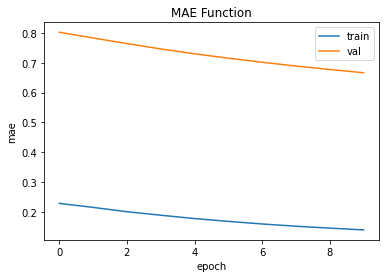

In [19]:
import matplotlib.pyplot as plt

mae = procces.history['mae']
val_mae = procces.history['val_mae']

plt.plot(mae)
plt.plot(val_mae)
plt.title('MAE Function')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.legend(['train', 'val'])
plt.show()

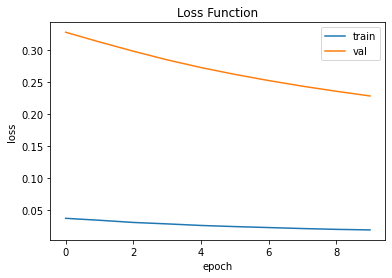

In [20]:
loss = procces.history['loss']
val_loss = procces.history['val_loss']

plt.plot(loss)
plt.plot(val_loss)
plt.title('Loss Function')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()